# Libraries

The libraries listed below will be used in the execution of this project. Assisting us from data processing to prediction.

In [1]:
!pip install unidecode
!pip install contractions
!pip install swifter
!pip install textblob
!pip install zipfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=719a8dce4757c85a2f935c564f031a16d106c80b84e956bed50ee38f5d5ab0c3
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from unidecode import unidecode
import contractions
import swifter
from textblob import TextBlob
import zipfile

# librosa to process audio files
import librosa as lb
import soundfile as sf
from scipy import signal

# play audio file
from IPython.display import Audio

# import libs for lemmitization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# download lemmitization data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

# Library to plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification

# one hot vector the Y values
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, plot_model
# Libraries for ML
from sklearn.model_selection import train_test_split

# Libraries to be used for the NN section
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, Masking, Dense, Input, MaxPooling1D, Flatten, Concatenate, Activation, Add, LayerNormalization, BatchNormalization, MaxPool1D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

# BERT
from transformers import BertTokenizer, TFBertForSequenceClassification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the audio files

Load the audio files to the collab drive to be used during the audio model process




In [4]:
# unpack zip file containing all IEMOCAP data
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/FP/NormalisedAudio.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Import the split dataframes

From the process previously written to extract, clean and convert all the information we are going to load each of the split dataframes. This will be used in this project to find the file locations, texts etc

In [5]:
# import split dataframes
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/train_df_full3.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/val_df_full3.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/test_df_full3.csv')

In [ ]:
# # import split dataframes
# train_df = train_df.sample(1000)
# val_df = val_df.sample(1000)
# test_df = test_df.sample(1000)

In [ ]:
# print the number of emotions that we see in the daframe
train_df.emotion_label.value_counts()

neutral       6394
angry         2129
joy           1799
sad           1656
frustrated    1478
surprise      1363
happy         1306
Name: emotion_label, dtype: int64

## Help functions

The function below assists us in plotting the confusion matrix for analysis of the results

In [6]:
# Function to plot the confusion matrix
def plot_confusion_matrix(true_val, pred_val, classes, title = 'Confusion Matrix'):
    """
        This function plots the confusion matrix
        true_val: True labels
        pred_val: Predicted labels
        classes: List of classes
    """
    # build and plot the confusion matrix with the true and predicted values
    cm = confusion_matrix(true_val, pred_val, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    # plot size
    plt.size=(6,6)
    # set title
    plt.title(title)
    plt.show()


Function to pickle variables and save them to the disk, which can be loaded later for future use.

In [7]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
  with open(filename, 'rb') as fp:
    data = pickle.load(fp)
  return data

## Create the emotion dict, list and length

In [8]:
# create a dictionary with the emotion_num and emotion_label
emotion_dict = dict(sorted(zip(train_df.emotion_num, train_df.emotion_label)))
num_emo_dict = {y: x for x, y in emotion_dict.items()}

print(emotion_dict)
print(num_emo_dict)

{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
{'neutral': 0, 'angry': 1, 'joy': 2, 'sad': 3, 'frustrated': 4, 'surprise': 5, 'happy': 6}


In [9]:
# Create label list for the confusion matrix
labels_list = list(emotion_dict.values())
print(labels_list)

['neutral', 'angry', 'joy', 'sad', 'frustrated', 'surprise', 'happy']


In [10]:
len_labels = len(labels_list)
len_labels

7

# Text Pre-processing

## Tokenization for text classification

Machine learning models cannot simply read the text as is, hence text must be transformed into a model-compatible format, therefore words must be tokenized, which is a process that translates words to a numerical representation

In [11]:
# Create the tokenizer object using the BERT vocab bert-base-uncased file
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Tokenizer vocab_size
vocab_size = len(tokenizer.vocab)
print(f'Vocab size: {vocab_size}')

Vocab size: 30522


In [13]:
# Function to tokenize the sentences using the BERT tokenizer
def bert_tokenizer(sentence, labels_val, max_len):
    """
        Perform required preprocessing steps for pretrained BERT.
        sentence: Sentence to tokenize
        labels: List of labels to be encoded
        max_len: Max length of the sentence (truncating point/padding point)
        return: Tokenized sentence
    """

    # Initialise lists to store outputs
    input_ids = []
    attention_masks = []

    # Iterate through each sentence and encode them
    # https://huggingface.co/transformers/v2.11.0/_modules/transformers/tokenization_utils.html#PreTrainedTokenizer.encode_plus
    # encode_plus method ^^
    for sent in sentence:
        try:
            encoded_sent = tokenizer.encode_plus(
                text = sent,                    # Sentence to encode
                add_special_tokens = True,      # [CLS] and [SEP] tokens
                max_length = max_len,           # Max length
                padding = 'max_length',         # Pad sentence to max length
                truncation = True,              # Truncate if longer than max length
                return_attention_mask = True    # Return attention mask
                )
        except:
            # print the sentence that caused the error and the error itself
            print(f'Error with sentence: {sent}')
            break

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to numpy arrays for training/prediction
    input_ids = np.array(input_ids, dtype='int64')
    attention_masks = np.array(attention_masks, dtype='int64')
    labels = np.array(labels_val, dtype='int64')

    return input_ids, attention_masks, labels

Execute the tokenization to all datasets using the bert_tokenizer function.

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16125 entries, 0 to 16124
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   dataset            16125 non-null  object
 1   filename           16125 non-null  object
 2   filepath           16125 non-null  object
 3   transcription      16125 non-null  object
 4   emotion_label      16125 non-null  object
 5   clean_text         16125 non-null  object
 6   emotion_num        16125 non-null  int64 
 7   nr_filepath        16125 non-null  object
 8   asr_transcription  16125 non-null  object
 9   asr_clean_text     16125 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [15]:
# Set the maximum length of the sentences to pad/truncate
max_len = 180

# Tokenize the train, validation and test sets
train_inputs, train_masks, train_labels = bert_tokenizer(train_df['clean_text'], train_df['emotion_num'], max_len)
val_inputs, val_masks, val_labels = bert_tokenizer(val_df['clean_text'],  val_df['emotion_num'], max_len)
test_inputs, test_masks, test_labels = bert_tokenizer(test_df['clean_text'], test_df['emotion_num'], max_len)

In [22]:
# Tokenize the train, validation and test sets
train_inputs_asr, train_masks_asr, train_labels = bert_tokenizer(train_df['asr_clean_text'], train_df['emotion_num'], max_len)
val_inputs_asr, val_masks_asr, val_labels = bert_tokenizer(val_df['asr_clean_text'],  val_df['emotion_num'], max_len)
test_inputs_asr, test_masks_asr, test_labels = bert_tokenizer(test_df['asr_clean_text'], test_df['emotion_num'], max_len)

In [23]:
# Print the shapes of the inputs
print(f'Train input_ids shape: {train_inputs.shape}')
print(f'Train train_labels shape: {train_labels.shape}')

print(f'Validation input_ids shape: {val_inputs.shape}')
print(f'Validation val_labels shape: {val_labels.shape}')

print(f'Test input_ids shape: {test_inputs.shape}')
print(f'Test test_labels shape: {test_labels.shape}')

Train input_ids shape: (16125, 180)
Train train_labels shape: (16125,)
Validation input_ids shape: (2016, 180)
Validation val_labels shape: (2016,)
Test input_ids shape: (2016, 180)
Test test_labels shape: (2016,)


Printing an example of a tokenized sentence

In [ ]:
# Print the original train input sentence and its tokenized ids
rand = np.random.randint(0, train_inputs.shape[0])

print(f'Original train sentence: {train_df.clean_text.iloc[rand]}')
print(f'Token ids of train sentence: {train_inputs[rand]}')
print(f'Decoded train sentence: {tokenizer.decode(train_inputs[rand])}')

Original train sentence: i be sorry , for the last time , why be not you two together again ?
Token ids of train sentence: [ 101 1045 2022 3374 1010 2005 1996 2197 2051 1010 2339 2022 2025 2017
 2048 2362 2153 1029  102    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0

# Audio Pre-processing

## Conv1D Audio Pre-processing


In [ ]:
def extract_features_1d(path):

    # extract the audio data and sample rate
    audio, sr = lb.load(path)

    # Store the results
    result = np.array([])

    # MFCC
    mfcc = np.mean(lb.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512))
    result = np.hstack((result, mfcc)) # stacking horizontally

    # ZCR
    zcr = np.mean(lb.feature.zero_crossing_rate(y=audio).T, axis=0)
    result = np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(lb.stft(audio))
    chroma_stft = np.mean(lb.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(lb.feature.rms(y=audio).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(lb.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [ ]:
def load_data(df):
    """
        Load the data and extract the features
        df: Dataframe
        return: X, y
    """
    X = []
    # iterate through each file and extract the features
    for file in df.nr_filepath:
        feature=extract_features_1d(file)
        X.append(feature)

    # convert X to numpy array and reshape
    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    # convert Y to numpy array
    y_list = df.emotion_num.values.tolist()
    y = np.array(y_list,dtype='int64')

    return X,y

In [ ]:
# Load the data
X_train_1d, y_train_1d = load_data(train_df)
X_val_1d, y_val_1d = load_data(val_df)
X_test_1d, y_test_1d = load_data(test_df)

In [ ]:


# sample usage
save_object(X_train_1d, '/content/drive/MyDrive/pickle/X_train_1d.pkl')
save_object(y_train_1d, '/content/drive/MyDrive/pickle/y_train_1d.pkl')

save_object(X_val_1d, '/content/drive/MyDrive/pickle/X_val_1d.pkl')
save_object(y_val_1d, '/content/drive/MyDrive/pickle/y_val_1d.pkl')

save_object(X_test_1d, '/content/drive/MyDrive/pickle/X_test_1d.pkl')
save_object(y_test_1d, '/content/drive/MyDrive/pickle/y_test_1d.pkl')

In [ ]:
X_train_1d = load_object('/content/drive/MyDrive/pickle/X_train_1d.pkl')
y_train_1d = load_object('/content/drive/MyDrive/pickle/y_train_1d.pkl')

X_val_1d = load_object('/content/drive/MyDrive/pickle/X_val_1d.pkl')
y_val_1d = load_object('/content/drive/MyDrive/pickle/y_val_1d.pkl')

X_test_1d = load_object('/content/drive/MyDrive/pickle/X_test_1d.pkl')
y_test_1d = load_object('/content/drive/MyDrive/pickle/y_test_1d.pkl')


In [ ]:
X_train_1d.shape, y_train_1d.shape, X_val_1d.shape, y_val_1d.shape,  X_test_1d.shape, y_test_1d.shape

((16125, 143, 1), (16125,), (2016, 143, 1), (2016,), (2016, 143, 1), (2016,))

## Conv2D Audio Pre-processing

The standardise function, calculates the standard deviation and mean values, followed by subtracting the mean from each feature and dividing by the standard deviation which generates a value between 0 and 1, ensuring consistent scales, that consequently mitigates bias in the learning process.

In [ ]:
def standardise(features):
    # calculate the standard dev
    std = np.std(features, axis=0)
    std[std == 0] = 1e-10 # handle division by zero by replacing it with small val
    mean = features.mean(axis=0)
    features = (features - mean) / std

    return features

The extract_audio_features function utilising librosa extracts the MFCC, ZCR, Chroma, RMS and Mel features in frequency bin format, which are stacked and standardised.

In [ ]:
def extract_audio_features_2d(file_path):
    """
        Extract MFCC, ZCR, Chroma, RMS and mel features from the audio files.
        file_path: Path to the audio file to extract features from
        return: Tuple containing the extracted features
    """

    # Extract features
    audio, sr = lb.load(file_path)

    # MFCC
    mfcc = lb.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)

    # Zero-crossing rate
    zcr = lb.feature.zero_crossing_rate(y=audio)

    # Chroma_stft
    stft  = np.abs(lb.stft(audio))
    chroma = lb.feature.chroma_stft(S=stft, sr=sr)

    # RMS
    rms = lb.feature.rms(y=audio)

    # MelSpectogram
    mel = lb.feature.melspectrogram(y=audio, sr=sr)

    # Combine features into a 2D array
    # Transpose the values making rows the features and columns the observations
    features = np.vstack([mfcc, zcr, chroma, rms, mel]).T
    features = standardise(features)

    # Reshape the features to match the format for the CNN
    features = features.reshape(1, features.shape[0], features.shape[1], 1)

    return features

The results are padded or truncated to maintain consistency accross the lenght sizes

In [ ]:
# pad the longest feature length
def pad_features(features):
    """
        Pad the longest feature length
        features: List of features to pad
        return: Padded features
    """
    # set the max length of features to 400
    max_length = 400

    #iterate over the features list and pad if the length is less than the max length else truncate to the max length
    for i in range(len(features)):
        if features[i].shape[1] < max_length:
            features[i] = np.pad(features[i], ((0, 0), (0, max_length - features[i].shape[1]), (0, 0), (0, 0)), mode='constant')
        else:
            features[i] = features[i][:, :max_length, :, :]

    return features

Iterate over the files and return the encoded values and their respective labels

In [ ]:
def load_data_2d(df):
    X = []

    # iterate over the file paths to extract the features
    for file in df.nr_filepath:
        feature=extract_audio_features_2d(file)
        X.append(feature)

    # pad the features
    X = pad_features(X)

    # Combine features from all files into a single NumPy array
    X = np.concatenate(X, axis=0)

    # convert df num_label to list and then to numpy array
    y = df.emotion_num.to_list()
    y = np.array(y,dtype='int64')

    return X,y

In [ ]:
# load the data for the train, val and test sets
# X_train_2d, y_train_2d = load_data_2d(train_df)
# X_val_2d, y_val_2d = load_data_2d(val_df)
# X_test_2d, y_test_2d = load_data_2d(test_df)

In [ ]:
# sample usage
# save_object(X_train_2d, '/content/drive/MyDrive/pickle/X_train_2d.pkl')
# save_object(y_train_2d, '/content/drive/MyDrive/pickle/y_train_2d.pkl')

# save_object(X_val_2d, '/content/drive/MyDrive/pickle/X_val_2d.pkl')
# save_object(y_val_2d, '/content/drive/MyDrive/pickle/y_val_2d.pkl')

# save_object(X_test_2d, '/content/drive/MyDrive/pickle/X_test_2d.pkl')
# save_object(y_test_2d, '/content/drive/MyDrive/pickle/y_test_2d.pkl')

In [17]:
X_train_2d = load_object('/content/drive/MyDrive/pickle/X_train_2d.pkl')
y_train_2d = load_object('/content/drive/MyDrive/pickle/y_train_2d.pkl')

X_val_2d = load_object('/content/drive/MyDrive/pickle/X_val_2d.pkl')
y_val_2d = load_object('/content/drive/MyDrive/pickle/y_val_2d.pkl')

X_test_2d = load_object('/content/drive/MyDrive/pickle/X_test_2d.pkl')
y_test_2d = load_object('/content/drive/MyDrive/pickle/y_test_2d.pkl')

X values should have 4 dimensions

y values should have 1 dimension

In [18]:
# print the shape of the data
X_train_2d.shape, y_train_2d.shape, X_val_2d.shape, y_val_2d.shape, X_test_2d.shape, y_test_2d.shape

((16125, 400, 162, 1),
 (16125,),
 (2016, 400, 162, 1),
 (2016,),
 (2016, 400, 162, 1),
 (2016,))

# Baseline model

## Text model (TextCNN)

In [ ]:
embedding_dim=256

textcnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Masking(mask_value=0.0), # Masking layer to handle the padded values
    # 1st Conv1D layer with kernel size 3 and relu activation
    Conv1D(256, kernel_size=3, activation='relu'),
    # 2nd Conv1D layer with kernel size 4 and relu activation
    Conv1D(128, kernel_size=4, activation='relu'),
    Dropout(0.2), # Dropout layer to reduce overfitting
    # 3rd Conv1D layer with kernel size 4 and relu activation
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(), # Pooling for feature extraction
    Dropout(0.5), # Dropout layer to reduce overfitting
    Dense(32, activation='relu'), # Dense layer with ReLU
    Dense(len_labels, activation='softmax') # Softmax output layer
],name='BaselineTextCNN')

# Compile the model and include Adam optimizer
textcnn_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001, epsilon=1e-08),
        metrics=['accuracy']
)

# Print the model summary
textcnn_model.summary()

Model: "BaselineTextCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 256)          7813632   
                                                                 
 masking (Masking)           (None, 180, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 178, 256)          196864    
                                                                 
 conv1d_1 (Conv1D)           (None, 175, 128)          131200    
                                                                 
 dropout (Dropout)           (None, 175, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 171, 64)           41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)            

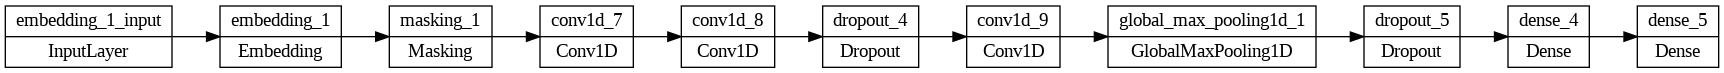

In [ ]:
plot_model(textcnn_model, rankdir="LR")

In [ ]:
# Train the model
h_text_cnn = textcnn_model.fit(
    train_inputs,
    train_labels,
    batch_size=32,
    epochs=4,
    validation_data=(val_inputs, val_labels),
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
504/504 [==============================] - 16s 24ms/step - loss: 1.0715 - accuracy: 0.6329 - val_loss: 1.5075 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 2/4
504/504 [==============================] - 4s 7ms/step - loss: 0.9673 - accuracy: 0.6616 - val_loss: 1.5133 - val_accuracy: 0.5213 - lr: 1.0000e-04
Epoch 3/4
504/504 [==============================] - 3s 7ms/step - loss: 0.9143 - accuracy: 0.6854 - val_loss: 1.5805 - val_accuracy: 0.5124 - lr: 1.0000e-04
Epoch 4/4
504/504 [==============================] - 3s 6ms/step - loss: 0.8636 - accuracy: 0.7008 - val_loss: 1.6133 - val_accuracy: 0.5238 - lr: 1.0000e-04


In [ ]:
textcnn_model.load_weights('/content/drive/MyDrive/BERT/textcnn_model2_tran.keras')

In [ ]:
textcnn_model.save('/content/drive/MyDrive/BERT/textcnn_model2_tran.keras')

## Conv1D Audio Model

In [ ]:
audio_conv1d_base_model = Sequential([
    # initial layer with input shape
    Conv1D(256, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_1d.shape[1], 1)),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # Conv1D layer with 256 filters and relu activation and maxpooling to reduce the feature maps
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # Conv2D layer with 128 filters and relu activation
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # Conv2D layer with 64 filters and relu activation
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dense(32, activation='relu'),
    Dropout(0.5), # Dropout layer to reduce overfitting
    Dense(len_labels, activation='softmax') # Output layer
], name='BaselineAudioConv1D')

# Compile the model
audio_conv1d_base_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

audio_conv1d_base_model.summary()


Model: "BaselineAudioConv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 256)            0         
 g1D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 6, 256)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 128)    

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(audio_conv1d_base_model, show_shapes=True)

In [ ]:
# Train the model
h_audio_base = audio_conv1d_base_model.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=4,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/4
504/504 [==============================] - 2s 5ms/step - loss: 1.7403 - accuracy: 0.3924 - val_loss: 1.6860 - val_accuracy: 0.3993 - lr: 2.0000e-05
Epoch 2/4
504/504 [==============================] - 2s 5ms/step - loss: 1.7341 - accuracy: 0.3919 - val_loss: 1.6858 - val_accuracy: 0.3988 - lr: 2.0000e-05
Epoch 3/4
504/504 [==============================] - 2s 5ms/step - loss: 1.7310 - accuracy: 0.3929 - val_loss: 1.6874 - val_accuracy: 0.4003 - lr: 2.0000e-05
Epoch 4/4
504/504 [==============================] - 2s 5ms/step - loss: 1.7224 - accuracy: 0.3947 - val_loss: 1.6731 - val_accuracy: 0.4013 - lr: 2.0000e-05


In [ ]:
audio_conv1d_base_model.save('/content/drive/MyDrive/BERT/audio_conv1d_base_model.keras')

In [ ]:
audio_conv1d_base_model.load_weights('/content/drive/MyDrive/BERT/audio_conv1d_base_model.keras')

# Further development models

### BERT Pre-Trained Model

The BERT model was built using a pre-trained model that is widely known in the NLP industry for its proven effectiveness. TFBertForSequenceClassification was used for the implementation, it combines BERT with a sequence classification head, ideal for text analysis. The 'bert-base-uncased' was used for transfer learning, pre-trained on BookCorpus and English Wikipedia. Training included the inputs, attention masks, and a dropout (0.5) to prevent overfitting. The final layer utilizes softmax activation to output projections.

In [19]:
bert_pretrained = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',          # 12-layer BERT model uncased vocab.
    num_labels = len_labels)      # The number of output labels

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def build_text_model(bert_model, shape_size):
    """
        This function builds the BERT Text model
        bert_model: BERT pretrained model
        shape_size: Shape size of the input
        return: BERT model
    """
    input_ids = Input(shape=(shape_size,), dtype=tf.int32, name='input_ids') # input ids layer
    attention_masks = Input(shape=(shape_size,), dtype=tf.int32, name='attention_masks') # attention masks layer

    bert_output = bert_model(input_ids, attention_masks)[0] # Output of the BERT model last hidden state
    output = Dropout(0.5)(bert_output) # Dropout layer to reduce overfitting
    output = Dense(len_labels, activation='softmax')(output) # Dense layer for classification
    model = Model(inputs = [input_ids, attention_masks],outputs = output, name='BERTModel')

    return model

# Build the BERT model
bert_model = build_text_model(bert_pretrained, max_len)
bert_model.summary()

Model: "BERTModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 180)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094876   ['input_ids[0][0]',           
 ification (TFBertForSequen  (loss=None, logits=(None,    23         'attention_masks[0][0]']     
 ceClassification)           7),                                                          

In [ ]:
# bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_2exec.keras')

In [25]:
bert_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

In [28]:
h_bert = bert_model.fit(
    [train_inputs_asr, train_masks_asr],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr], val_labels),
    epochs=2,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/2
1008/1008 [==============================] - 218s 216ms/step - loss: 1.4925 - accuracy: 0.4977 - val_loss: 1.5959 - val_accuracy: 0.4638 - lr: 2.0000e-05
Epoch 2/2
1008/1008 [==============================] - 218s 217ms/step - loss: 1.3179 - accuracy: 0.5503 - val_loss: 1.6412 - val_accuracy: 0.4782 - lr: 2.0000e-05


In [ ]:
bert_model.save_weights('/content/drive/MyDrive/BERT/bert_model_FP4_59.keras')

In [ ]:
bert_model.save_weights('/content/drive/MyDrive/BERT/bert_model_58.keras')

In [24]:
# bert_model.save_weights('/content/drive/MyDrive/BERT/bert_model_FP_57.keras')

bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_58.keras')

# bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_FP_57.keras')

In [ ]:
# Predict the results using the unseen test inputs
y_pred_bert = bert_model.predict([test_inputs, test_masks])
y_pred_bert = np.argmax(y_pred_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_bert))

63/63 [==============================] - 9s 115ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       799
           1       0.47      0.51      0.49       266
           2       0.51      0.42      0.46       225
           3       0.38      0.43      0.40       207
           4       0.48      0.51      0.50       185
           5       0.60      0.60      0.60       170
           6       0.68      0.52      0.59       164

    accuracy                           0.58      2016
   macro avg       0.55      0.53      0.53      2016
weighted avg       0.58      0.58      0.58      2016



In [ ]:
h_bert = bert_model.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_data=([val_inputs, val_masks], val_labels),
    epochs=4,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
1008/1008 [==============================] - 216s 215ms/step - loss: 1.2428 - accuracy: 0.5753 - val_loss: 1.4380 - val_accuracy: 0.5699 - lr: 2.0000e-05
Epoch 2/4
1008/1008 [==============================] - 216s 214ms/step - loss: 1.1552 - accuracy: 0.6046 - val_loss: 1.4969 - val_accuracy: 0.5784 - lr: 2.0000e-05
Epoch 3/4
1008/1008 [==============================] - 216s 214ms/step - loss: 1.0734 - accuracy: 0.6407 - val_loss: 1.5599 - val_accuracy: 0.5818 - lr: 2.0000e-05
Epoch 4/4
1008/1008 [==============================] - 216s 214ms/step - loss: 0.9963 - accuracy: 0.6726 - val_loss: 1.6058 - val_accuracy: 0.5660 - lr: 2.0000e-05


In [ ]:
# bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_IEMOCAP.keras')

In [ ]:
# Predict the results using the unseen test inputs
y_pred_bert = bert_model.predict([test_inputs, test_masks])
y_pred_bert = np.argmax(y_pred_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_bert))

63/63 [==============================] - 7s 114ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       799
           1       0.48      0.48      0.48       266
           2       0.50      0.41      0.45       225
           3       0.41      0.35      0.38       207
           4       0.49      0.45      0.47       185
           5       0.47      0.65      0.55       170
           6       0.57      0.57      0.57       164

    accuracy                           0.57      2016
   macro avg       0.52      0.52      0.51      2016
weighted avg       0.57      0.57      0.57      2016



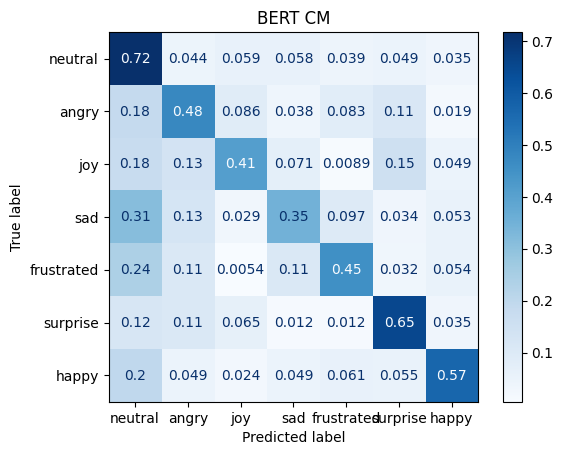

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_bert, labels_list, "BERT CM")

# Conv1D Models

## Conv1D with BatchNormalisation

In [ ]:

cnn_batchnorm = Sequential([
    # 1st Conv1D layer with kernel size 5 and relu activation
    Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train_1d.shape[1],1)),
    BatchNormalization(), # Batch normalization layer to normalise the input
    MaxPooling1D(pool_size=5,strides=2,padding='same'), # Maxpooling layer to reduce the feature maps
    # 2nd Conv1D layer with kernel size 4 and relu activation
    Conv1D(512,kernel_size=4,strides=1,padding='same',activation='relu'),
    BatchNormalization(), # Batch normalization layer to normalise the input
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 3rd Conv1D layer with kernel size 3 and relu activation
    Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 4th Conv1D layer with kernel size 2 and relu activation
    Conv1D(128,kernel_size=2,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 5th Conv1D layer with kernel size 2 and relu activation
    Conv1D(64,kernel_size=2,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Flatten(), # Flatten layer to convert 2D to 1D
    # Dense layer with 64 neurons and relu activation
    Dense(64,activation='relu'),
    BatchNormalization(), # normalise the values
    Dense(len_labels,activation='softmax') # Output layer
])

cnn_batchnorm.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

cnn_batchnorm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 143, 512)          3072      
                                                                 
 batch_normalization (Batch  (None, 143, 512)          2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 72, 512)           0         
 D)                                                              
                                                                 
 conv1d_4 (Conv1D)           (None, 72, 512)           1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 72, 512)           2048      
 chNormalization)                                                
                                                        

In [ ]:
# Train the model
h_cnn_batchnorm = cnn_batchnorm.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/20
504/504 [==============================] - 5s 10ms/step - loss: 1.4487 - accuracy: 0.4614 - val_loss: 1.6527 - val_accuracy: 0.3963 - lr: 2.0000e-05
Epoch 2/20
504/504 [==============================] - 5s 11ms/step - loss: 1.4329 - accuracy: 0.4712 - val_loss: 1.7364 - val_accuracy: 0.3457 - lr: 2.0000e-05
Epoch 3/20
504/504 [==============================] - 5s 10ms/step - loss: 1.4128 - accuracy: 0.4755 - val_loss: 1.8216 - val_accuracy: 0.2946 - lr: 2.0000e-05
Epoch 4/20
504/504 [==============================] - 5s 10ms/step - loss: 1.3928 - accuracy: 0.4811 - val_loss: 1.9032 - val_accuracy: 0.2867 - lr: 2.0000e-05
Epoch 5/20
504/504 [==============================] - 5s 10ms/step - loss: 1.3779 - accuracy: 0.4918 - val_loss: 1.7003 - val_accuracy: 0.3750 - lr: 2.0000e-05


In [ ]:
# predict on test data
y_pred_batch = cnn_batchnorm.predict(X_test_1d)

# convert predictions to one hot vectors
y_pred_batch = np.argmax(y_pred_batch, axis=1)

# Convert from one hot vectors to integers
# y_labels = np.argmax(y_test_1d, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(y_test_1d, y_pred_batch))

63/63 [==============================] - 0s 2ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.51      0.66      0.57       799
           1       0.27      0.38      0.31       266
           2       0.20      0.14      0.17       225
           3       0.55      0.24      0.34       207
           4       0.30      0.42      0.35       185
           5       0.26      0.04      0.06       170
           6       0.38      0.16      0.22       164

    accuracy                           0.41      2016
   macro avg       0.35      0.29      0.29      2016
weighted avg       0.40      0.41      0.38      2016



In [ ]:
cnn_batchnorm.save('/content/drive/MyDrive/BERT/cnn_batchnorm.keras')

In [ ]:
cnn_batchnorm.load_weights('/content/drive/MyDrive/BERT/cnn_batchnorm.keras')

## Conv1D with Bi-LSTM

In [ ]:
conv1d_lstm_model = Sequential([
    # initial layer with input shape and relu activation
    Conv1D(256, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_1d.shape[1], 1)),
    MaxPooling1D(pool_size=5, padding = 'same'), # Maxpooling layer to reduce the feature maps
    # Conv1D layer with 256 filters and relu activation and maxpooling to downsample the feature maps
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # 1st BiLSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # 2nd BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dense(32, activation='relu'), # Dense layer with ReLU
    Dropout(0.3), # Dropout layer to reduce overfitting
    Dense(len_labels, activation='softmax') # Output layer
])

# Compiling the cov1d_lstm model
conv1d_lstm_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

conv1d_lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 143, 256)          1536      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 29, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 29, 256)           327936    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 6, 256)            0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 6, 256)            394240    
 al)                                                             
                                                      

In [ ]:
# Train the model
h_conv1d_lstm = conv1d_lstm_model.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/20
504/504 [==============================] - 5s 9ms/step - loss: 1.7286 - accuracy: 0.3839 - val_loss: 1.6651 - val_accuracy: 0.4003 - lr: 3.2000e-06
Epoch 2/20
504/504 [==============================] - 5s 9ms/step - loss: 1.6844 - accuracy: 0.3981 - val_loss: 1.6480 - val_accuracy: 0.4033 - lr: 3.2000e-06
Epoch 3/20
504/504 [==============================] - 5s 9ms/step - loss: 1.6614 - accuracy: 0.4009 - val_loss: 1.6362 - val_accuracy: 0.4043 - lr: 3.2000e-06
Epoch 4/20
504/504 [==============================] - 4s 9ms/step - loss: 1.6524 - accuracy: 0.3992 - val_loss: 1.6303 - val_accuracy: 0.4072 - lr: 3.2000e-06
Epoch 5/20
504/504 [==============================] - 4s 9ms/step - loss: 1.6453 - accuracy: 0.4009 - val_loss: 1.6241 - val_accuracy: 0.4048 - lr: 3.2000e-06
Epoch 6/20
504/504 [==============================] - 5s 9ms/step - loss: 1.6374 - accuracy: 0.4027 - val_loss: 1.6192 - val_accuracy: 0.4072 - lr: 3.2000e-06
Epoch 7/20
504/504 [==========================

In [ ]:
# predict on test data
y_pred_conv1d_lstm = conv1d_lstm_model.predict(X_test_1d)

# convert predictions to one hot vectors
y_pred_conv1d_lstm = np.argmax(y_pred_conv1d_lstm, axis=1)

# Convert from one hot vectors to integers
# y_labels = np.argmax(y_test_1d, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(y_test_1d, y_pred_conv1d_lstm))

In [ ]:
conv1d_lstm_model.save('/content/drive/MyDrive/BERT/conv1d_lstm_model.keras')

In [ ]:
conv1d_lstm_model.load_weights('/content/drive/MyDrive/BERT/conv1d_lstm_model.keras')

# Conv2D

## Conv2D Model

The audio model employs a Conv2D architecture built using a sequential tf.keras model, containing multiple Conv2D layers and several filter widths sizes (256, 128, 64). This filter approach collects information at various spatial scales, with bigger filters capturing wider patterns and smaller filters capturing finer details. To down-sample spatial data while keeping critical information during feature extraction, MaxPooling2D layers are used. To avoid overfitting, two Dropout layers for regularisation were added and a dense layer with softmax to output emotion class predictions.

In [ ]:
conv2d_model = Sequential([
    # initial layer with input shape
    Conv2D(256, (3, 3), activation='relu', input_shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1)),
    # MaxPooling2D to downsample the feature maps
    MaxPooling2D((2, 2)),
    # Conv2D layer with 256 filters and relu activation
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # Conv2D layer with 128 filters and relu activation
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv2D layer with 64 filters and relu activation
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dropout(0.2), # Dropout layer to reduce overfitting
    Dense(32, activation='relu'),
    Dense(len_labels, activation='softmax') # Output layer
])

conv2d_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

conv2d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 160, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 80, 256)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 78, 256)      590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 39, 256)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 98, 39, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 37, 128)       2

In [ ]:
h_conv2d = conv2d_model.fit(
    X_train_2d,
    y_train_2d,
    validation_data=(X_val_2d, y_val_2d),
    epochs=20,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4),
      ]
)

In [ ]:
conv2d_model.save('/content/drive/MyDrive/BERT/CNN2D_model.keras')

In [ ]:
conv2d_model = tf.keras.models.load_model('/content/drive/MyDrive/BERT/CNN2D_model.keras')

In [ ]:
# print the results
y_pred_c2d = conv2d_model.predict(X_test_2d)
y_pred_c2d = np.argmax(y_pred_c2d, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c2d, zero_division=1))

63/63 [==============================] - 7s 40ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.47      0.88      0.61       799
           1       0.38      0.19      0.26       266
           2       0.22      0.02      0.03       225
           3       0.48      0.26      0.33       207
           4       0.29      0.30      0.30       185
           5       0.17      0.01      0.02       170
           6       0.29      0.09      0.14       164

    accuracy                           0.44      2016
   macro avg       0.33      0.25      0.24      2016
weighted avg       0.37      0.44      0.35      2016



## Conv2D Bi-LSTM

In [ ]:
X_train_2d.shape

(16125, 400, 162, 1)

In [ ]:
# Create a Conv2D + biLSTM model for the audio data


In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, Dropout, TimeDistributed

conv2d_lstm_model = Sequential([
    # 1st Conv2D layer with kernel size 3,3 and relu activation
    Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)), # Maxpooling layer to reduce the feature maps
    # 2nd Conv2D layer with kernel size 3,3 and relu activation
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    # TimeDistributed layer to flatten the output of the conv layers for the lstm
    TimeDistributed(Flatten()),
    # 1st BiLSTM layer to learn temporal dependencies
    Bidirectional(LSTM(128, return_sequences=True)),
    # 2nd BiLSTM layer
    Bidirectional(LSTM(64)),
    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len_labels, activation='softmax')
])

conv2d_lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

conv2d_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 160, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 80, 256)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 78, 128)      295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 39, 128)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 98, 39, 128)       0         
                                                                 
 time_distributed (TimeDist  (None, 98, 4992)          0

In [ ]:
# train the model
conv2d_lstm_model.fit(
        X_train_2d,
        y_train_2d,
        validation_data=(X_val_2d, y_val_2d),
        epochs=10,
        batch_size=32,
        callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ])

Epoch 1/10
504/504 [==============================] - 128s 233ms/step - loss: 1.7344 - accuracy: 0.3956 - val_loss: 1.6726 - val_accuracy: 0.3958 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 111s 219ms/step - loss: 1.6554 - accuracy: 0.4019 - val_loss: 1.6189 - val_accuracy: 0.3988 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 111s 219ms/step - loss: 1.6149 - accuracy: 0.4050 - val_loss: 1.5779 - val_accuracy: 0.4008 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 110s 219ms/step - loss: 1.5826 - accuracy: 0.4136 - val_loss: 1.5574 - val_accuracy: 0.4082 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 110s 219ms/step - loss: 1.5658 - accuracy: 0.4172 - val_loss: 1.5411 - val_accuracy: 0.4132 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 111s 219ms/step - loss: 1.5379 - accuracy: 0.4247 - val_loss: 1.5039 - val_accuracy: 0.4231 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# run the model on the test data
conv2d_lstm_model.evaluate(X_test_2d, y_test_2d)

# predict on test data
y_pred_conv2d_lstm = conv2d_lstm_model.predict(X_test_2d)

# convert predictions to values
y_pred_conv2d_lstm = np.argmax(y_pred_conv2d_lstm, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(y_test_2d, y_pred_conv2d_lstm, zero_division=1))

63/63 [==============================] - 2s 30ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.46      0.92      0.61       799
           1       0.50      0.05      0.10       266
           2       1.00      0.00      0.00       225
           3       0.54      0.32      0.40       207
           4       0.36      0.44      0.40       185
           5       1.00      0.00      0.00       170
           6       0.43      0.12      0.19       164

    accuracy                           0.45      2016
   macro avg       0.61      0.26      0.24      2016
weighted avg       0.57      0.45      0.35      2016



In [ ]:
conv2d_lstm_model.save('/content/drive/MyDrive/BERT/conv2d_lstm_model.keras')

In [30]:
conv2d_lstm_model.load_weights('/content/drive/MyDrive/BERT/conv2d_lstm_model.keras')

## ConvLSTM2D Model

In [ ]:
X_train_2D_4vec = X_train_2d.reshape(-1, 1, *X_train_2d.shape[1:])
X_val_2D_4vec = X_val_2d.reshape(-1, 1, *X_val_2d.shape[1:])
X_test_2D_4vec = X_test_2d.reshape(-1, 1, *X_test_2d.shape[1:])

In [ ]:
X_train_2D_4vec.shape, X_val_2D_4vec.shape, X_test_2D_4vec.shape

((16125, 1, 400, 162, 1), (2016, 1, 400, 162, 1), (2016, 1, 400, 162, 1))

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, Dropout, ConvLSTM2D, Attention, TimeDistributed


input_shape = (X_train_2D_4vec.shape[1], X_train_2D_4vec.shape[2], X_train_2D_4vec.shape[3], X_train_2D_4vec.shape[4])

convlstm2d_model = Sequential([
    # 2 Conv2D layers of size 64 and 32 with relu activation
    ConvLSTM2D(64, kernel_size=(3, 3), return_sequences=True, input_shape=input_shape),
    ConvLSTM2D(32, kernel_size=(3, 3), return_sequences=True),
    # TimeDistributed layer to flatten the output of the conv layers for the lstm
    TimeDistributed(Flatten()),
    # Dense layers with relu activation
    Dense(32, activation='relu'),
    Dropout(0.2), # Dropout layer to prevent overfitting
    Dense(len_labels, activation='softmax')
])

convlstm2d_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

convlstm2d_model.summary()

In [ ]:
# train the model
convlstm2d_model.fit(
        X_train_2D_4vec,
        y_train_2d,
        validation_data=(X_val_2D_4vec, y_val_2d),
        epochs=10,
        batch_size=16,
        callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ])

Epoch 1/10
1008/1008 [==============================] - 252s 241ms/step - loss: 1.7050 - accuracy: 0.3688 - val_loss: 1.6515 - val_accuracy: 0.3645 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 236s 234ms/step - loss: 1.5478 - accuracy: 0.3400 - val_loss: 1.6620 - val_accuracy: 0.3551 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 236s 234ms/step - loss: 1.3087 - accuracy: 0.3150 - val_loss: 1.7752 - val_accuracy: 0.3152 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 236s 234ms/step - loss: 0.9855 - accuracy: 0.3013 - val_loss: 1.9125 - val_accuracy: 0.3090 - lr: 8.0000e-06
Epoch 5/10
1008/1008 [==============================] - 236s 234ms/step - loss: 0.8446 - accuracy: 0.2925 - val_loss: 2.0463 - val_accuracy: 0.3049 - lr: 8.0000e-06


In [ ]:
# run the model on the test data
# convlstm2d_model.evaluate(X_test_2D_4vec, y_test_2d)

# predict on test data
y_pred_convlstm2d = convlstm2d_model.predict(X_test_2D_4vec)

# convert predictions to values
y_pred_convlstm2d = np.argmax(y_pred_convlstm2d, axis=1)
y_test_2d = np.argmax(y_test_2d, axis=1)

In [ ]:
# print the index to class and the algorithm performance
# print(emotion_dict)
print(classification_report(y_test_2d, y_pred_convlstm2d, zero_division=1))

In [ ]:
convlstm2d_model.save('/content/drive/MyDrive/BERT/convlstm2d_model.keras')

# Model Fusion - Late Fusion

In [32]:

def build_fusion_model(text_model, text_input, audio_model, audio_input, len_labels, freeze_text=False, freeze_audio=False):
    """
        This function builds the late fusion model using the text and audio models
        text_model: Text model to be used
        text_input: Full text input layer
        audio_model: Audio model to be used
        audio_input: Full audio input layer
        len_labels: Number of labels
    """
    # Freeze the audio model layers
    if freeze_audio:
        for layer in audio_model.layers:
            layer.trainable = False

    # Freeze the text model layers
    if freeze_text:
        for layer in text_model.layers:
            layer.trainable = False

    # Add the text and audio input layers
    audio_inputs = audio_model(audio_input)
    text_inputs = text_model(text_input)
    # Concatenate the text and audio inputs to form a fusion model
    merged = Concatenate(name='Concatenation')([audio_inputs, text_inputs])
    merged = Dense(256, activation='relu', name = '256DenseLayerWithReLU')(merged)
    merged = Dropout(0.5, name='DropOut.5')(merged)
    merged = Dense(128, activation='relu', name = '128DenseLayerWithReLU')(merged)
    merged = Dropout(0.2, name='DropOut.2')(merged)
    output = Dense(len_labels, activation='softmax', name = "OutputSoftmax")(merged)

    # create the model
    model = Model([text_input, audio_input], output, name='LateFusionModel')

    return model

## Baseline Model Fusion

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# freeze the text and audio models
freeze_text=False
freeze_audio=False

# create the fusion model
base_fusion_model = build_fusion_model(textcnn_model, textcnn_input, audio_conv1d_base_model, audio_input, len_labels)

base_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BaselineAudioConv1D (Seque  (None, 7)                    536775    ['BaseAudioInput[0][0]']      
 ntial)                                                                                           
                                                                                    

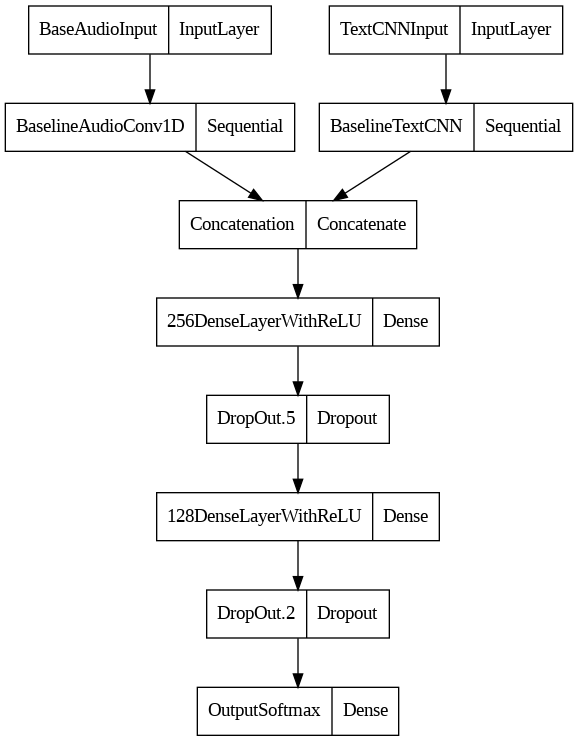

In [ ]:
plot_model(base_fusion_model)

In [ ]:
# compile the model
base_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_base = base_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 17s 26ms/step - loss: 1.7366 - accuracy: 0.4081 - val_loss: 1.6661 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 5s 10ms/step - loss: 1.4866 - accuracy: 0.4483 - val_loss: 1.5724 - val_accuracy: 0.4400 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 5s 9ms/step - loss: 1.3100 - accuracy: 0.5328 - val_loss: 1.5627 - val_accuracy: 0.4727 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 5s 9ms/step - loss: 1.1800 - accuracy: 0.6123 - val_loss: 1.5780 - val_accuracy: 0.5089 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 4s 9ms/step - loss: 1.0745 - accuracy: 0.6734 - val_loss: 1.6076 - val_accuracy: 0.5074 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 5s 9ms/step - loss: 0.9971 - accuracy: 0.7033 - val_loss: 1.6217 - val_accuracy: 0.5084 - lr: 2.0000e-05
Epoch 7/10
504/504 [=======================

In [ ]:
# print the results
y_pred = base_fusion_model.predict([test_inputs, X_test_1d])
y_pred = np.argmax(y_pred, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred, zero_division=1))

63/63 [==============================] - 0s 2ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       799
           1       0.38      0.32      0.34       266
           2       0.43      0.43      0.43       225
           3       0.41      0.22      0.28       207
           4       0.35      0.41      0.38       185
           5       0.45      0.50      0.47       170
           6       0.53      0.55      0.54       164

    accuracy                           0.51      2016
   macro avg       0.45      0.44      0.44      2016
weighted avg       0.50      0.51      0.50      2016



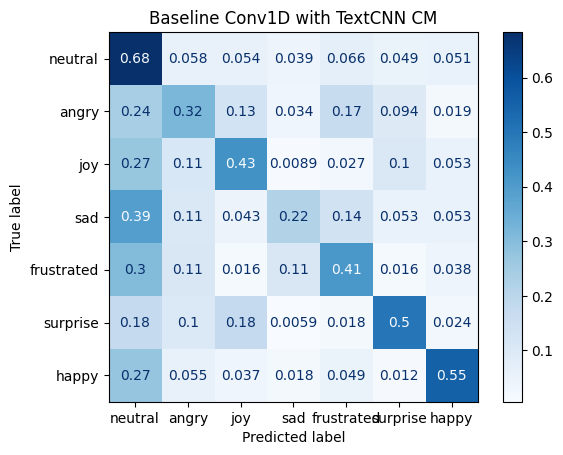

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred, labels_list, "Baseline Conv1D with TextCNN CM")

## Baseline Conv1D with BERT Model Fusion

In [ ]:
# BERT input layer
bert_input = Input(shape=(max_len,), name='BERTInput')


bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# bert_output = bert_model(input_ids, attention_masks)[0] # Output of the BERT model last hidden state

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# freeze the text and audio models
freeze_text=False
freeze_audio=False

# create the fusion model
bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], audio_conv1d_base_model, audio_input, len_labels)

bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

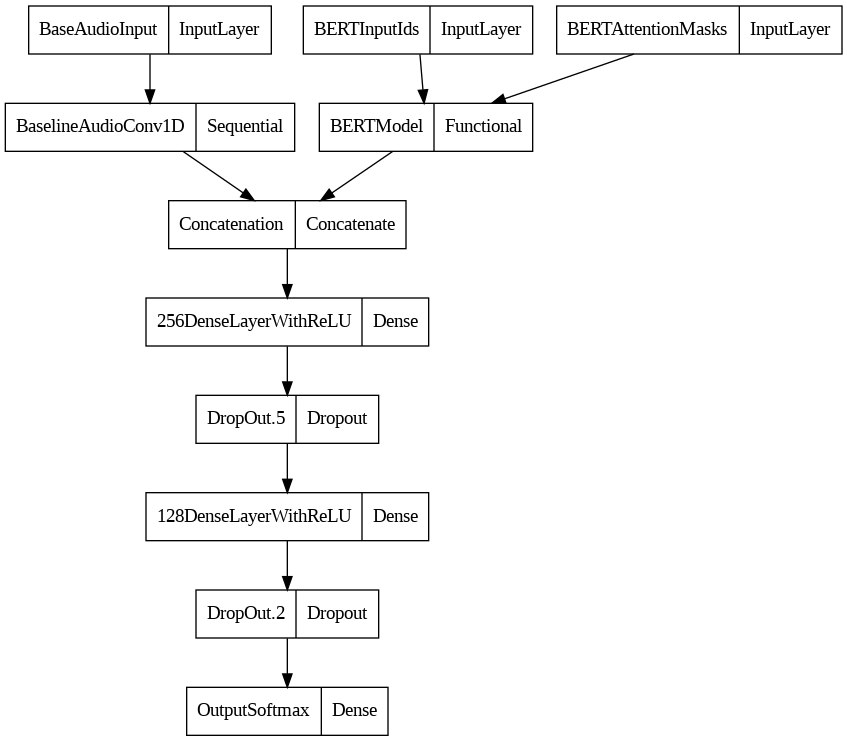

In [ ]:
plot_model(bert_fusion_model)

In [ ]:
# compile the model
bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_base_bert = bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 238s 395ms/step - loss: 1.8222 - accuracy: 0.3913 - val_loss: 1.7326 - val_accuracy: 0.4236 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 197s 392ms/step - loss: 1.5899 - accuracy: 0.4381 - val_loss: 1.5808 - val_accuracy: 0.4335 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 197s 391ms/step - loss: 1.4359 - accuracy: 0.4747 - val_loss: 1.5526 - val_accuracy: 0.4965 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 197s 391ms/step - loss: 1.3186 - accuracy: 0.5728 - val_loss: 1.5221 - val_accuracy: 0.5149 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 197s 391ms/step - loss: 1.2424 - accuracy: 0.6249 - val_loss: 1.5223 - val_accuracy: 0.5466 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 197s 392ms/step - loss: 1.1920 - accuracy: 0.6368 - val_loss: 1.4985 - val_accuracy: 0.5164 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# print the results
y_pred = bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred = np.argmax(y_pred, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred, zero_division=1))

63/63 [==============================] - 9s 115ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       799
           1       0.43      0.55      0.48       266
           2       0.47      0.52      0.49       225
           3       0.47      0.23      0.31       207
           4       0.41      0.39      0.40       185
           5       0.55      0.58      0.57       170
           6       0.56      0.57      0.56       164

    accuracy                           0.56      2016
   macro avg       0.51      0.51      0.50      2016
weighted avg       0.56      0.56      0.56      2016



In [ ]:
bert_fusion_model.save('/content/drive/MyDrive/BERT/bert_base_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


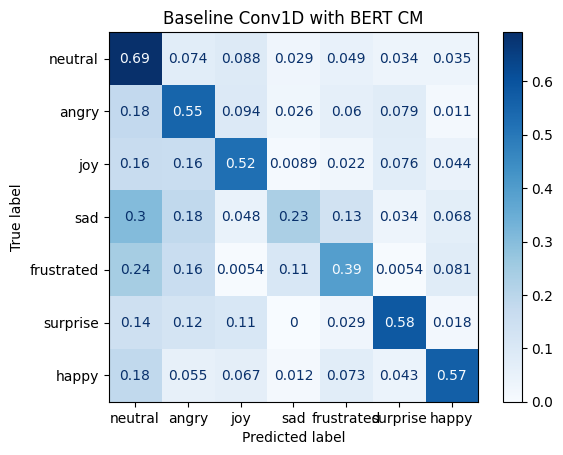

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred, labels_list, "Baseline Conv1D with BERT CM")

## Conv1D BatchNorm with TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_batchnorm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioBatchNormInput')

# create the fusion model
batchnorm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, cnn_batchnorm, audio_batchnorm_input, len_labels)

batchnorm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioBatchNormInput (Input  [(None, 143, 1)]             0         []                            
 Layer)                                                                                           
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    1554887   ['AudioBatchNormInput[0][0]'] 
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

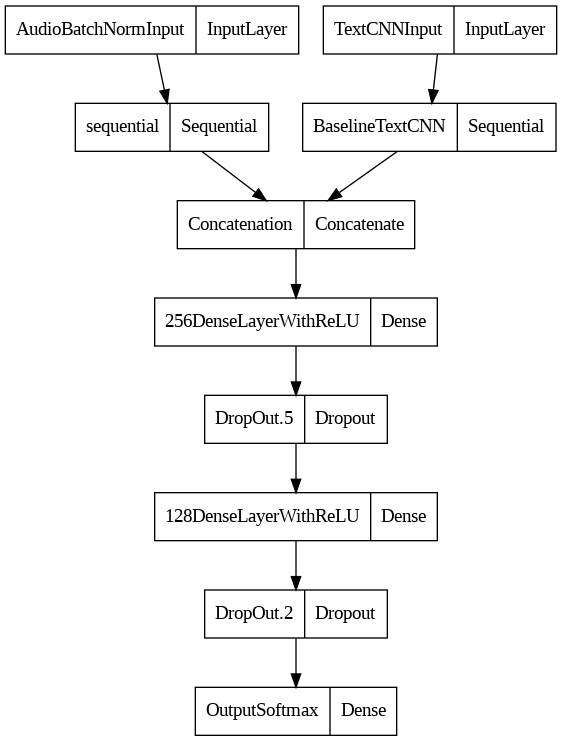

In [ ]:
plot_model(batchnorm_fusion_model)

In [ ]:
# compile the model
batchnorm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_batchnorm = batchnorm_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 22s 31ms/step - loss: 1.8171 - accuracy: 0.3962 - val_loss: 1.7301 - val_accuracy: 0.3998 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 8s 15ms/step - loss: 1.5761 - accuracy: 0.4409 - val_loss: 1.5748 - val_accuracy: 0.4335 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 8s 15ms/step - loss: 1.3763 - accuracy: 0.5318 - val_loss: 1.5072 - val_accuracy: 0.5050 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 7s 14ms/step - loss: 1.2191 - accuracy: 0.6376 - val_loss: 1.4906 - val_accuracy: 0.5238 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 7s 15ms/step - loss: 1.1001 - accuracy: 0.6837 - val_loss: 1.4805 - val_accuracy: 0.5258 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 7s 14ms/step - loss: 1.0228 - accuracy: 0.6943 - val_loss: 1.4846 - val_accuracy: 0.5238 - lr: 2.0000e-05
Epoch 7/10
504/504 [===================

In [ ]:
# print the results
y_pred = batchnorm_fusion_model.predict([test_inputs, X_test_1d])
y_pred = np.argmax(y_pred, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred, zero_division=1))

63/63 [==============================] - 0s 3ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       799
           1       0.39      0.36      0.37       266
           2       0.41      0.43      0.42       225
           3       0.35      0.29      0.32       207
           4       0.48      0.30      0.37       185
           5       0.50      0.49      0.50       170
           6       0.59      0.52      0.56       164

    accuracy                           0.52      2016
   macro avg       0.48      0.45      0.46      2016
weighted avg       0.51      0.52      0.51      2016



In [ ]:
# print the results
y_pred_batch_textcnn = batchnorm_fusion_model.predict([test_inputs, X_test_1d])
y_pred_batch_textcnn = np.argmax(y_pred_batch_textcnn, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_batch_textcnn, zero_division=1))

63/63 [==============================] - 12s 184ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       799
           1       0.39      0.36      0.37       266
           2       0.41      0.43      0.42       225
           3       0.35      0.29      0.32       207
           4       0.48      0.30      0.37       185
           5       0.50      0.49      0.50       170
           6       0.59      0.52      0.56       164

    accuracy                           0.52      2016
   macro avg       0.48      0.45      0.46      2016
weighted avg       0.51      0.52      0.51      2016



In [ ]:
batchnorm_fusion_model.save_weights('/content/drive/MyDrive/BERT/batchnorm_fusion_model.keras')

In [ ]:
batchnorm_fusion_model.load_weights('/content/drive/MyDrive/BERT/batchnorm_fusion_model.keras')

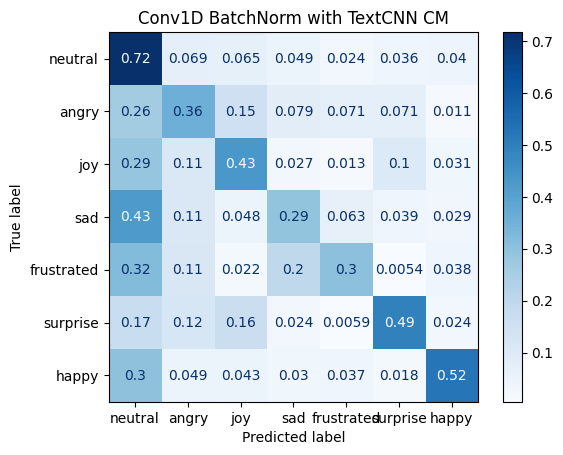

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_batch_textcnn, labels_list, "Conv1D BatchNorm with TextCNN CM")

## Conv1D BatchNorm with BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_batchnorm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioBatchNormInput')

# create the fusion model
batchn_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], cnn_batchnorm, audio_batchnorm_input, len_labels)

batchn_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioBatchNormInput (Input  [(None, 143, 1)]             0         []                            
 Layer)                                                                                           
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# compile the model
batchn_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_cnnbn_bert = batchn_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 242s 399ms/step - loss: 1.8234 - accuracy: 0.3500 - val_loss: 1.6941 - val_accuracy: 0.4385 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 200s 396ms/step - loss: 1.5291 - accuracy: 0.4478 - val_loss: 1.5573 - val_accuracy: 0.4340 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 200s 396ms/step - loss: 1.3941 - accuracy: 0.4887 - val_loss: 1.5215 - val_accuracy: 0.4945 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 199s 396ms/step - loss: 1.2913 - accuracy: 0.5628 - val_loss: 1.4914 - val_accuracy: 0.5228 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 200s 396ms/step - loss: 1.1918 - accuracy: 0.6163 - val_loss: 1.4766 - val_accuracy: 0.5218 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 200s 396ms/step - loss: 1.1141 - accuracy: 0.6505 - val_loss: 1.4616 - val_accuracy: 0.5417 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# print the results
y_pred_batchn_bert = batchn_bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred_batchn_bert = np.argmax(y_pred_batchn_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_batchn_bert, zero_division=1))

63/63 [==============================] - 7s 117ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.67      0.73      0.69       799
           1       0.38      0.46      0.41       266
           2       0.51      0.52      0.51       225
           3       0.33      0.39      0.36       207
           4       0.50      0.35      0.41       185
           5       0.42      0.16      0.24       170
           6       0.55      0.52      0.54       164

    accuracy                           0.53      2016
   macro avg       0.48      0.45      0.45      2016
weighted avg       0.53      0.53      0.53      2016



In [ ]:
batchn_bert_fusion_model.save('/content/drive/MyDrive/BERT/batchn_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


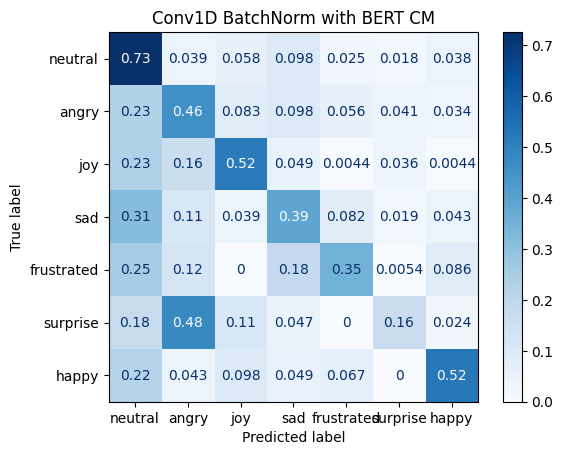

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_batchn_bert, labels_list, "Conv1D BatchNorm with BERT CM")

## Conv1D Bi-LSTM with TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioConv1DLSTMInput')

# create the fusion model
c1d_lstm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv1d_lstm_model, audio_input, len_labels)

c1d_lstm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv1DLSTMInput (Inpu  [(None, 143, 1)]             0         []                            
 tLayer)                                                                                          
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 7)                    912903    ['AudioConv1DLSTMInput[0][0]']
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

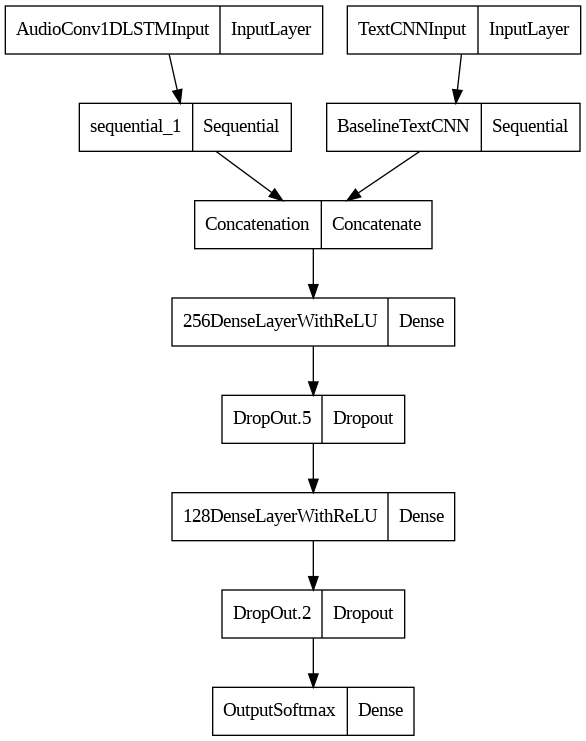

In [ ]:
plot_model(c1d_lstm_fusion_model)

In [ ]:
# compile the model
c1d_lstm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c1d_lstm = c1d_lstm_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 24s 31ms/step - loss: 1.7491 - accuracy: 0.3943 - val_loss: 1.6605 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 1.4868 - accuracy: 0.4060 - val_loss: 1.5718 - val_accuracy: 0.3988 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 7s 13ms/step - loss: 1.3178 - accuracy: 0.5242 - val_loss: 1.5483 - val_accuracy: 0.5243 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 6s 13ms/step - loss: 1.1878 - accuracy: 0.6505 - val_loss: 1.5490 - val_accuracy: 0.5154 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 6s 13ms/step - loss: 1.0881 - accuracy: 0.6941 - val_loss: 1.5562 - val_accuracy: 0.5174 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 6s 13ms/step - loss: 1.0095 - accuracy: 0.7087 - val_loss: 1.5801 - val_accuracy: 0.5134 - lr: 2.0000e-05
Epoch 7/10
504/504 [===================

In [ ]:
# print the results
y_pred = c1d_lstm_fusion_model.predict([test_inputs, X_test_1d])
y_pred = np.argmax(y_pred, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred, zero_division=1))

63/63 [==============================] - 2s 4ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.62      0.67      0.65       799
           1       0.36      0.32      0.34       266
           2       0.42      0.41      0.42       225
           3       0.18      0.08      0.11       207
           4       0.33      0.44      0.38       185
           5       0.48      0.52      0.50       170
           6       0.51      0.57      0.53       164

    accuracy                           0.49      2016
   macro avg       0.42      0.43      0.42      2016
weighted avg       0.47      0.49      0.48      2016



In [ ]:
# print the results
y_pred_c1d_lstm_tcnn = c1d_lstm_fusion_model.predict([test_inputs, X_test_1d])
y_pred_c1d_lstm_tcnn = np.argmax(y_pred_c1d_lstm_tcnn, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c1d_lstm_tcnn, zero_division=1))

63/63 [==============================] - 7s 84ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.62      0.67      0.65       799
           1       0.36      0.32      0.34       266
           2       0.42      0.41      0.42       225
           3       0.18      0.08      0.11       207
           4       0.33      0.44      0.38       185
           5       0.48      0.52      0.50       170
           6       0.51      0.57      0.53       164

    accuracy                           0.49      2016
   macro avg       0.42      0.43      0.42      2016
weighted avg       0.47      0.49      0.48      2016



In [ ]:
c1d_lstm_fusion_model.save_weights('/content/drive/MyDrive/BERT/c1d_lstm_fusion_model.keras')

In [ ]:
c1d_lstm_fusion_model.load_weights('/content/drive/MyDrive/BERT/c1d_lstm_fusion_model.keras')

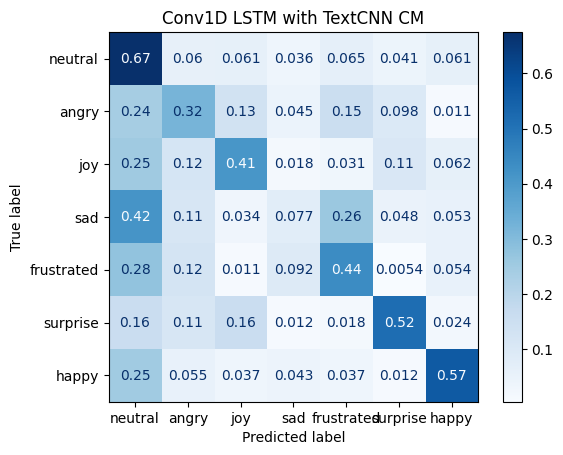

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c1d_lstm_tcnn, labels_list, "Conv1D LSTM with TextCNN CM")

## Conv1D Bi-LSTM with BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_lstm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioConv1DLSTMInput')

# create the fusion model
c1dlstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv1d_lstm_model, audio_lstm_input, len_labels)

c1dlstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv1DLSTMInput (Inpu  [(None, 143, 1)]             0         []                            
 tLayer)                                                                                          
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# compile the model
c1dlstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c1dlstm_bert = c1dlstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
504/504 [==============================] - 244s 401ms/step - loss: 1.7597 - accuracy: 0.3968 - val_loss: 1.6729 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 199s 395ms/step - loss: 1.5435 - accuracy: 0.4128 - val_loss: 1.5629 - val_accuracy: 0.4360 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 199s 395ms/step - loss: 1.4232 - accuracy: 0.4726 - val_loss: 1.5496 - val_accuracy: 0.4593 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 200s 396ms/step - loss: 1.3312 - accuracy: 0.5411 - val_loss: 1.4841 - val_accuracy: 0.5040 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 199s 395ms/step - loss: 1.2317 - accuracy: 0.6049 - val_loss: 1.4835 - val_accuracy: 0.5154 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 199s 396ms/step - loss: 1.1832 - accuracy: 0.6348 - val_loss: 1.4566 - val_accuracy: 0.5253 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# print the results
y_pred_c1dlstm_bert = c1dlstm_bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred_c1dlstm_bert = np.argmax(y_pred_c1dlstm_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c1dlstm_bert, zero_division=1))

63/63 [==============================] - 7s 117ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       799
           1       0.26      0.61      0.36       266
           2       0.31      0.57      0.41       225
           3       0.30      0.14      0.20       207
           4       0.49      0.15      0.23       185
           5       1.00      0.01      0.01       170
           6       0.59      0.21      0.31       164

    accuracy                           0.44      2016
   macro avg       0.52      0.33      0.31      2016
weighted avg       0.54      0.44      0.42      2016



In [ ]:
c1dlstm_bert_fusion_model.save('/content/drive/MyDrive/BERT/c1dlstm_bert_fusion_model.keras')

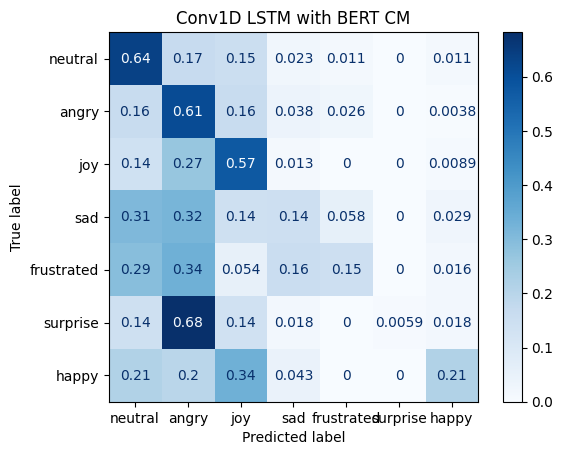

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c1dlstm_bert, labels_list, "Conv1D LSTM with BERT CM")

## Conv2D with TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DInput')

# create the fusion model
c2d_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv2d_model, audio_input, len_labels)

c2d_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DInput (InputLay  [(None, 400, 162, 1)]        0         []                            
 er)                                                                                              
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    1338567   ['AudioConv2DInput[0][0]']    
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

In [ ]:
# plot_model(c1d_lstm_fusion_model)

In [ ]:
# compile the model
c2d_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c2d_textcnn = c2d_fusion_model.fit(
    [train_inputs, X_train_2d],
    train_labels,
    validation_data=([val_inputs, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 139s 134ms/step - loss: 1.7558 - accuracy: 0.3740 - val_loss: 1.6229 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 133s 132ms/step - loss: 1.4807 - accuracy: 0.4304 - val_loss: 1.5375 - val_accuracy: 0.4325 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.3441 - accuracy: 0.4897 - val_loss: 1.5259 - val_accuracy: 0.4623 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.2621 - accuracy: 0.5181 - val_loss: 1.5282 - val_accuracy: 0.4583 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.2065 - accuracy: 0.5462 - val_loss: 1.5239 - val_accuracy: 0.4762 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.1650 - accuracy: 0.5618 - val_loss: 1.5396 - val_accuracy: 0.4807 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# print the results
y_pred_c2d_textcnn = c2d_fusion_model.predict([test_inputs, X_test_2d])
y_pred_c2d_textcnn = np.argmax(y_pred_c2d_textcnn, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c2d_textcnn, zero_division=1))

63/63 [==============================] - 3s 40ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       799
           1       0.39      0.23      0.29       266
           2       0.29      0.56      0.38       225
           3       0.37      0.36      0.36       207
           4       0.43      0.48      0.45       185
           5       1.00      0.01      0.01       170
           6       0.54      0.46      0.49       164

    accuracy                           0.50      2016
   macro avg       0.52      0.40      0.38      2016
weighted avg       0.55      0.50      0.47      2016



In [ ]:
c2d_fusion_model.save('/content/drive/MyDrive/BERT/c2d_fusion_model.keras')

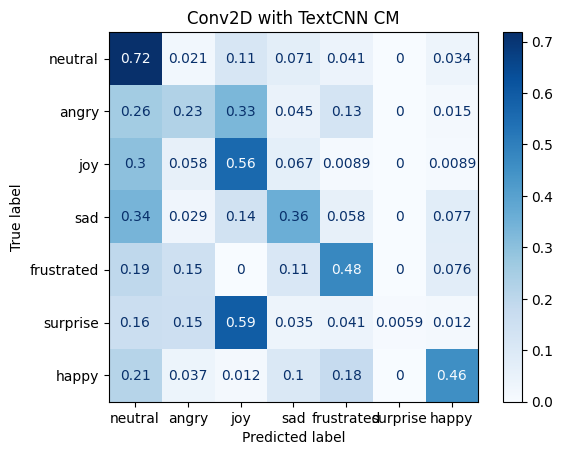

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_textcnn, labels_list, "Conv2D with TextCNN CM")

## Conv2D with BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DInput')

# create the fusion model
c2d_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_model, audio_input, len_labels)

c2d_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DInput (InputLay  [(None, 400, 162, 1)]        0         []                            
 er)                                                                                              
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# compile the model
c2d_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c2d_bert = c2d_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 398s 350ms/step - loss: 1.7200 - accuracy: 0.4038 - val_loss: 1.6255 - val_accuracy: 0.4276 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 376s 373ms/step - loss: 1.4663 - accuracy: 0.4538 - val_loss: 1.6279 - val_accuracy: 0.4067 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 376s 373ms/step - loss: 1.3238 - accuracy: 0.5374 - val_loss: 1.5984 - val_accuracy: 0.5099 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 376s 374ms/step - loss: 1.2259 - accuracy: 0.5906 - val_loss: 1.5870 - val_accuracy: 0.5094 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 376s 373ms/step - loss: 1.1593 - accuracy: 0.6133 - val_loss: 1.6715 - val_accuracy: 0.5114 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 376s 373ms/step - loss: 1.1178 - accuracy: 0.6292 - val_loss: 1.6587 - val_accuracy: 0.5060 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# print the results
y_pred_c2d_bert = c2d_bert_fusion_model.predict([test_inputs, test_masks, X_test_2d])
y_pred_c2d_bert = np.argmax(y_pred_c2d_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c2d_bert, zero_division=1))

63/63 [==============================] - 10s 156ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       799
           1       0.27      0.62      0.37       266
           2       0.46      0.46      0.46       225
           3       1.00      0.00      0.00       207
           4       1.00      0.00      0.00       185
           5       0.54      0.56      0.55       170
           6       0.70      0.51      0.59       164

    accuracy                           0.51      2016
   macro avg       0.66      0.41      0.38      2016
weighted avg       0.65      0.51      0.47      2016



In [ ]:
c2d_bert_fusion_model.save('/content/drive/MyDrive/BERT/c2d_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


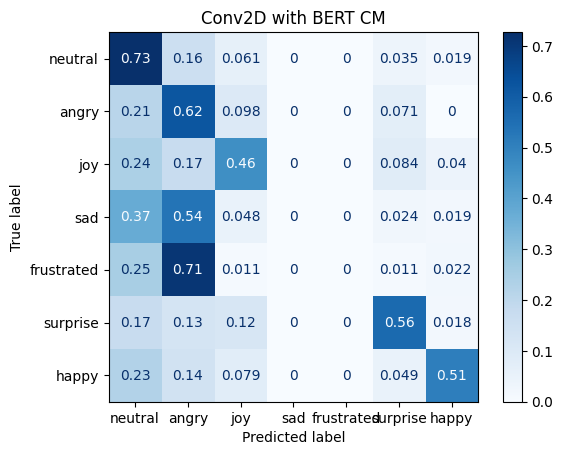

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_bert, labels_list, "Conv2D with BERT CM")

## Conv2D Bi-LSTM with TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
c2d_bilstm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv2d_lstm_model, audio_input, len_labels)

c2d_bilstm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    5710215   ['AudioConv2DBiLSTMInput[0][0]
                                                                    ']                            
                                                                                    

In [ ]:
# compile the model
c2d_bilstm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c2d_bilstm_textcnn = c2d_bilstm_fusion_model.fit(
    [train_inputs, X_train_2d],
    train_labels,
    validation_data=([val_inputs, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 140s 129ms/step - loss: 1.8123 - accuracy: 0.3555 - val_loss: 1.6752 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.5125 - accuracy: 0.4608 - val_loss: 1.5412 - val_accuracy: 0.4692 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.3397 - accuracy: 0.5384 - val_loss: 1.4851 - val_accuracy: 0.4633 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.2353 - accuracy: 0.5618 - val_loss: 1.4807 - val_accuracy: 0.4608 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 125s 124ms/step - loss: 1.1836 - accuracy: 0.5666 - val_loss: 1.4578 - val_accuracy: 0.4613 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.1439 - accuracy: 0.5715 - val_loss: 1.4569 - val_accuracy: 0.4688 - lr: 2.0000e-05


In [ ]:
# print the results
y_predc2d_bilstm_textcnn = c2d_bilstm_fusion_model.predict([test_inputs, X_test_2d])
y_predc2d_bilstm_textcnn = np.argmax(y_predc2d_bilstm_textcnn, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_predc2d_bilstm_textcnn, zero_division=1))

63/63 [==============================] - 3s 29ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       799
           1       0.36      0.36      0.36       266
           2       0.31      0.55      0.39       225
           3       0.22      0.02      0.04       207
           4       0.29      0.50      0.37       185
           5       0.36      0.02      0.04       170
           6       0.37      0.08      0.13       164

    accuracy                           0.47      2016
   macro avg       0.36      0.33      0.29      2016
weighted avg       0.44      0.47      0.42      2016



In [ ]:
c2d_bilstm_fusion_model.save('/content/drive/MyDrive/BERT/c2d_bilstm_fusion_model.keras')

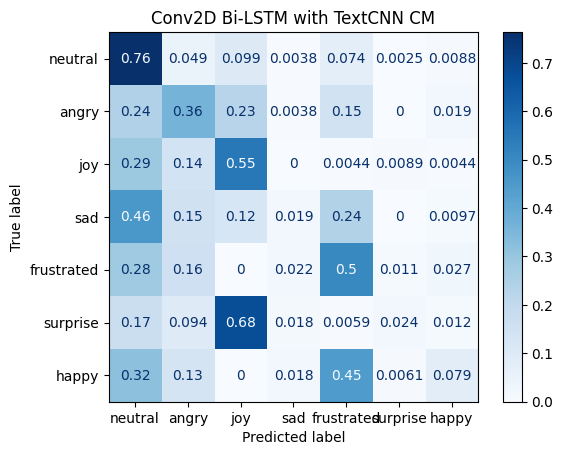

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_predc2d_bilstm_textcnn, labels_list, "Conv2D Bi-LSTM with TextCNN CM")

## Conv2D Bi-LSTM with BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
c2d_lstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_lstm_model, audio_input, len_labels)

c2d_lstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# compile the model
c2d_lstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_c2d_lstm_bert = c2d_lstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

In [ ]:
h_c2d_lstm_bert = c2d_lstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=2,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/2
1008/1008 [==============================] - 389s 338ms/step - loss: 0.7307 - accuracy: 0.7669 - val_loss: 1.5775 - val_accuracy: 0.5729 - lr: 2.0000e-05
Epoch 2/2
1008/1008 [==============================] - 331s 329ms/step - loss: 0.6964 - accuracy: 0.7818 - val_loss: 1.6234 - val_accuracy: 0.5823 - lr: 2.0000e-05


In [ ]:
h_c2d_lstm_bert = c2d_lstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=2,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

In [ ]:
# print the results
y_pred_c2d_lstm_bert = c2d_lstm_bert_fusion_model.predict([test_inputs, test_masks, X_test_2d])
y_pred_c2d_lstm_bert = np.argmax(y_pred_c2d_lstm_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_c2d_lstm_bert, zero_division=1))

63/63 [==============================] - 14s 136ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       799
           1       0.49      0.34      0.40       266
           2       0.48      0.54      0.51       225
           3       0.53      0.30      0.39       207
           4       0.44      0.61      0.51       185
           5       0.61      0.46      0.52       170
           6       0.67      0.55      0.61       164

    accuracy                           0.59      2016
   macro avg       0.56      0.51      0.52      2016
weighted avg       0.58      0.59      0.57      2016



In [ ]:
c2d_lstm_bert_fusion_model.save('/content/drive/MyDrive/BERT/c2d_lstm_bert_fusion_model2.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
c2d_lstm_bert_fusion_model.load_weights('/content/drive/MyDrive/BERT/c2d_lstm_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


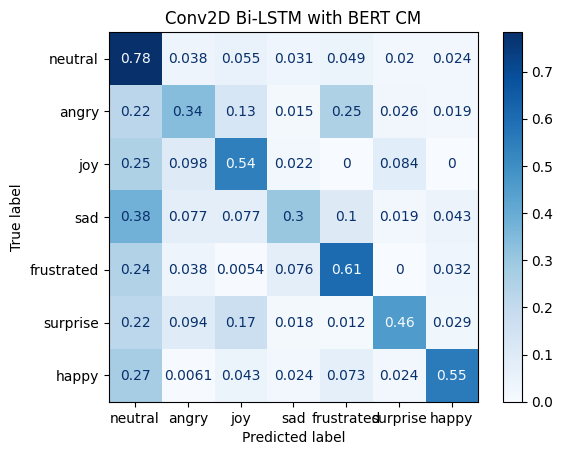

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_lstm_bert, labels_list, "Conv2D Bi-LSTM with BERT CM")

## ConvLSTM2D with TextCNN

In [ ]:
# # text cnn input layer
# textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# # audio input layer
# audio_input = Input(shape=(X_train_2D_4vec.shape[1], X_train_2D_4vec.shape[2], X_train_2D_4vec.shape[3], X_train_2D_4vec.shape[4]), name='AudioConvLSTM2DInput')

# # create the fusion model
# convlstm2d_fusion_model = build_fusion_model(textcnn_model, textcnn_input, convlstm2d_model, audio_input, len_labels)

# convlstm2d_fusion_model.summary()

In [ ]:
# # compile the model
# convlstm2d_fusion_model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
#     metrics=['accuracy']
# )

In [ ]:
# # Train the model
# h_convlstm2d_textcnn = convlstm2d_fusion_model.fit(
#     [train_inputs, X_train_2D_4vec],
#     train_labels,
#     validation_data=([val_inputs, X_val_2D_4vec], val_labels),
#     epochs=10,
#     batch_size=16,
#     callbacks=[
#         ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
#         EarlyStopping(monitor='val_accuracy', patience=4)
#     ]
# )

In [ ]:
# # print the results
# y_pred_convlstm2d_textcnn = convlstm2d_fusion_model.predict([test_inputs, X_test_2D_4vec])
# y_pred_convlstm2d_textcnn = np.argmax(y_pred, axis=1)

# # print the index to class and the algorithm performance
# print(emotion_dict)
# print(classification_report(test_labels, y_pred_convlstm2d_textcnn, zero_division=1))

In [ ]:
# convlstm2d_fusion_model.save('/content/drive/MyDrive/BERT/convlstm2d_fusion_model.keras')

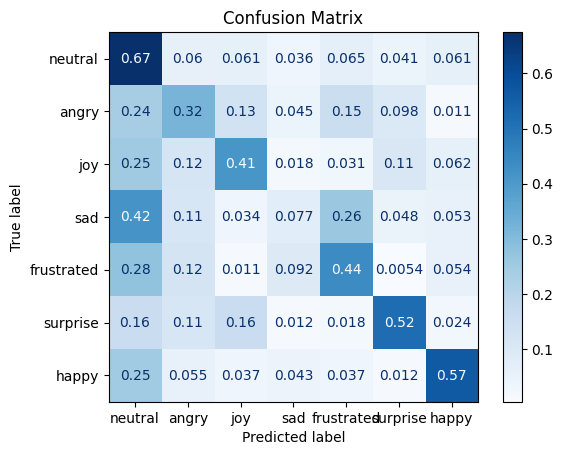

In [ ]:
# # create the confusion matrix
# plot_confusion_matrix(test_labels, y_pred, labels_list, "ConvLSTM2D with TextCNN CM")

## ASR Baseline Conv1D with BERT Model Fusion

In [ ]:
# BERT input layer
bert_input = Input(shape=(max_len,), name='BERTInput')


bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# bert_output = bert_model(input_ids, attention_masks)[0] # Output of the BERT model last hidden state

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# create the fusion model
asr_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], audio_conv1d_base_model, audio_input, len_labels)

asr_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# compile the model
asr_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_asr_base_bert = asr_bert_fusion_model.fit(
    [train_inputs_asr, train_masks_asr, X_train_1d],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 243s 397ms/step - loss: 1.8678 - accuracy: 0.3213 - val_loss: 1.7655 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 198s 393ms/step - loss: 1.7308 - accuracy: 0.3973 - val_loss: 1.7089 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 198s 393ms/step - loss: 1.6870 - accuracy: 0.3976 - val_loss: 1.6919 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 198s 393ms/step - loss: 1.6597 - accuracy: 0.4037 - val_loss: 1.6769 - val_accuracy: 0.3958 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 198s 394ms/step - loss: 1.6456 - accuracy: 0.4183 - val_loss: 1.6720 - val_accuracy: 0.4296 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 198s 394ms/step - loss: 1.6080 - accuracy: 0.4408 - val_loss: 1.6836 - val_accuracy: 0.4201 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# print the results
y_pred_asr = asr_bert_fusion_model.predict([test_inputs_asr, test_masks_asr, X_test_1d])
y_pred_asr = np.argmax(y_pred_asr, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_asr, zero_division=1))

63/63 [==============================] - 7s 115ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       799
           1       0.29      0.49      0.37       266
           2       0.21      0.23      0.22       225
           3       0.32      0.23      0.27       207
           4       1.00      0.00      0.00       185
           5       1.00      0.00      0.00       170
           6       1.00      0.00      0.00       164

    accuracy                           0.41      2016
   macro avg       0.62      0.24      0.21      2016
weighted avg       0.56      0.41      0.34      2016



In [ ]:
asr_bert_fusion_model.save('/content/drive/MyDrive/BERT/asr_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
asr_bert_fusion_model.load_weights('/content/drive/MyDrive/BERT/asr_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


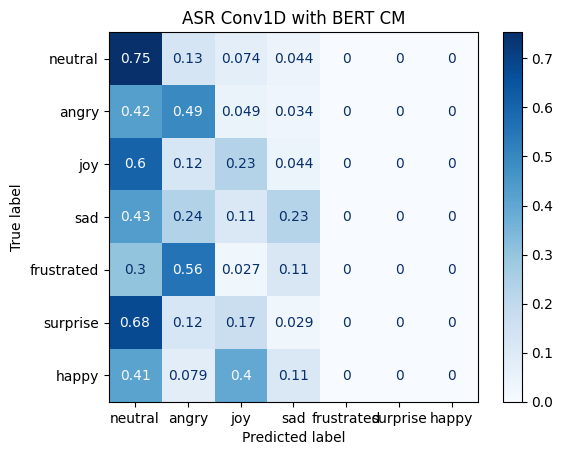

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr, labels_list, "ASR Conv1D with BERT CM")

## ASR Conv2D Bi-LSTM with BERT

In [33]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
asr_c2d_lstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_lstm_model, audio_input, len_labels)

asr_c2d_lstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [34]:
# compile the model
asr_c2d_lstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_asr_c2d_lstm_bert = asr_c2d_lstm_bert_fusion_model.fit(
    [train_inputs_asr, train_masks_asr, X_train_2d],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 393s 341ms/step - loss: 1.7547 - accuracy: 0.3962 - val_loss: 1.7138 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 333s 330ms/step - loss: 1.6875 - accuracy: 0.3981 - val_loss: 1.6747 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.6274 - accuracy: 0.4188 - val_loss: 1.6509 - val_accuracy: 0.4152 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.5881 - accuracy: 0.4351 - val_loss: 1.6102 - val_accuracy: 0.4216 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.5244 - accuracy: 0.4582 - val_loss: 1.5689 - val_accuracy: 0.4266 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.4765 - accuracy: 0.4726 - val_loss: 1.5593 - val_accuracy: 0.4271 - lr: 2.0000e-05
Epoch 7/10

In [41]:
# print the results
y_pred_asr_c2d_lstm_bert = asr_c2d_lstm_bert_fusion_model.predict([test_inputs_asr, test_masks_asr, X_test_2d])
y_pred_asr_c2d_lstm_bert = np.argmax(y_pred_asr_c2d_lstm_bert, axis=1)

# print the index to class and the algorithm performance
print(emotion_dict)
print(classification_report(test_labels, y_pred_asr_c2d_lstm_bert, zero_division=1))

63/63 [==============================] - 9s 140ms/step
{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
              precision    recall  f1-score   support

           0       0.55      0.65      0.59       799
           1       0.42      0.33      0.37       266
           2       0.29      0.26      0.27       225
           3       0.25      0.33      0.28       207
           4       0.49      0.50      0.50       185
           5       0.29      0.09      0.14       170
           6       0.61      0.50      0.55       164

    accuracy                           0.46      2016
   macro avg       0.41      0.38      0.39      2016
weighted avg       0.45      0.46      0.45      2016



In [42]:
asr_c2d_lstm_bert_fusion_model.save('/content/drive/MyDrive/BERT/asr_c2d_lstm_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [36]:
asr_c2d_lstm_bert_fusion_model.load_weights('/content/drive/MyDrive/BERT/asr_c2d_lstm_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


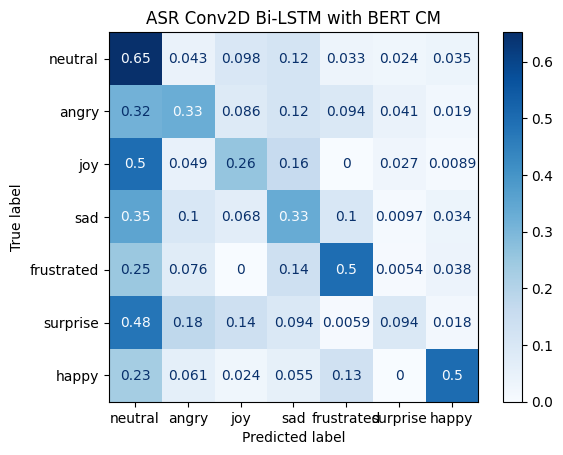

In [43]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr_c2d_lstm_bert, labels_list, "ASR Conv2D Bi-LSTM with BERT CM")